# Code for Preprocessing + BLS
* Searches NASA Exoplanet Archive for TOIs with missing planet radius
* Download FFI data from TESS with adaptive aperture selection
* Uses BLS to estimate parameters
* Graphs raw & normalized light curve, BLS with best period
* Graphs lightcurve folded/binned at BLS period and catalog period

We have two main functions:
1) Analyzes and plots for 1 target
2) Analyzes for 20 TOIs (and saves light curves to csv) + plots for 1 target

Both functions will extract a light-curve, clean/normalize, run BLS search for period, estimate uncertainity, and give plots.

---

# Functions
search_tois_with_missing_radius():
* Searches NASA Exoplanet Archive, returns TOIs where planet radius is unknown and  star has usable data

analyze_missing_radius_toi():
* Downloads TESS TPF data
* Uses adaptive aperture and extracts light curve
* Cleans, normalizes, flattens, stiches light curve data
* Runs BLS transit search (+/- 20% of period)
* Calculates period, depth, duration and gives uncertainity estimates
* Folds light curves and give plots of full light curve, BLS periodogram, folded transit curve

batch_analyze_missing_radius(df, num_candidates=20, save_lcs=True):
* Considers num_candidate=20 TOIs from the list of exoplanets with missing radius
* Analyzes each one using analyze_missing_radius_toi()
* Saves num_candidates=20  to csv file with recovered transit parameters
---

# How to use Notebook
Execute the code using the second code cell "if __name__ == "__main__":"
* df_missing = search_tois_with_missing_radius() finds TOIs with missing radius
* To analyze different TOIs:
  * Change index in "candidate_index = #"
  * This will graph all plots, run BLS, and give a summary of all calculations
* batch_results analyzes multiple TOIs at a time (currently set to 20) 
  * Runs BLS on all TOIs 
  * Creates csv file of light-curves
---

In [13]:
import os
os.environ['LIGHTKURVE_CACHE'] = "C:/lkcache"
import lightkurve as lk
from astropy.timeseries import BoxLeastSquares
from astroquery.mast import Catalogs
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ============================================================================
# GET CATALOG PARAMETERS (PERIOD, DEPTH, DURATION)
# ============================================================================
def get_catalog_transit_params(tic_id, toi_name=None):
    """
    Gets transit depth and duration from catalogs
    """
    
    catalog_params = {
        'depth': None,
        'depth_err': None,
        'duration': None,
        'duration_err': None
    }
    
    print(f"\n  Looking through catalogs for transit parameters...")
    
    # Looks through TOI catalog 
    try:
        if toi_name is not None:
            toi_table = NasaExoplanetArchive.query_criteria(
                table="TOI",
                select="toi, pl_trandep, pl_trandeperr1, pl_trandur, pl_trandurerr1",
                where=f"toi='{toi_name}'"
            )
            
            if len(toi_table) > 0:
                # Depth in ppm, convert to fraction
                if not np.ma.is_masked(toi_table['pl_trandep'][0]) and toi_table['pl_trandep'][0] is not None:
                    catalog_params['depth'] = float(toi_table['pl_trandep'][0]) / 1e6  # ppm to fraction
                    print(f"    ✓ Found catalog depth: {toi_table['pl_trandep'][0]:.1f} ppm")
                
                if not np.ma.is_masked(toi_table['pl_trandeperr1'][0]) and toi_table['pl_trandeperr1'][0] is not None:
                    catalog_params['depth_err'] = float(toi_table['pl_trandeperr1'][0]) / 1e6
                    print(f"      Error: ±{toi_table['pl_trandeperr1'][0]:.1f} ppm")
                
                # Duration in hours, convert to days
                if not np.ma.is_masked(toi_table['pl_trandur'][0]) and toi_table['pl_trandur'][0] is not None:
                    catalog_params['duration'] = float(toi_table['pl_trandur'][0]) / 24.0  # hours to days
                    print(f"    ✓ Found catalog duration: {toi_table['pl_trandur'][0]:.3f} hours")
                
                if not np.ma.is_masked(toi_table['pl_trandurerr1'][0]) and toi_table['pl_trandurerr1'][0] is not None:
                    catalog_params['duration_err'] = float(toi_table['pl_trandurerr1'][0]) / 24.0
                    print(f"      Error: ±{toi_table['pl_trandurerr1'][0]:.3f} hours")
    
    except Exception as e:
        print(f"       Could not find TOI catalog: {e}")
    
    # Print none if values unknown (missing in catalog)
    if catalog_params['depth'] is None and catalog_params['duration'] is None:
        print(f"    Note: No transit depth/duration found in catalogs")
    
    return catalog_params


# ============================================================================
# EXTRACTING LIGHT CURVES
# ============================================================================
def extract_lightcurve_from_ffi(target, sector=None, cutout_size=15):
    """Extract light curve from TESS Full Frame Images - returns both raw and cleaned"""
    
    if isinstance(target, (int, np.integer)):
        target = int(target)
        target = f"TIC {target}"
    
    print(f"\nExtracting FFI light curve for {target}")
    print("This may take awhile...")
    
    try:
        print("  Searching for FFI data...")
        search_result = lk.search_tesscut(target)
        
        if len(search_result) == 0:
            print(f"    No FFI data found")
            return None, None
        
        if sector is not None:
            search_result = search_result[search_result.mission == f'TESS Sector {sector}']
            if len(search_result) == 0:
                print(f"    No data in sector {sector}")
                return None, None
        
        print(f"    Found FFI data in {len(search_result)} sector(s)")
        
        print(f"  Downloading {cutout_size}x{cutout_size} pixel cutouts...")
        tpf_collection = search_result.download_all(cutout_size=cutout_size)
        
        if tpf_collection is None or len(tpf_collection) == 0:
            print("    Download failed")
            return None, None
        
        lc_list = []
        raw_lc_list = []
        
        for tpf in tpf_collection:
            try:
                print(f"  Processing Sector {tpf.sector}...")
                
                aperture_mask = None
                test_mask = tpf.create_threshold_mask(threshold=5, reference_pixel='center')
                if 5 <= test_mask.sum() <= 25:
                    aperture_mask = test_mask
                    print(f"    Using threshold=5 mask ({test_mask.sum()} pixels)")
                
                if aperture_mask is None:
                    test_mask = tpf.create_threshold_mask(threshold=3, reference_pixel='center')
                    if 5 <= test_mask.sum() <= 30:
                        aperture_mask = test_mask
                        print(f"    Using threshold=3 mask ({test_mask.sum()} pixels)")
                
                if aperture_mask is None or aperture_mask.sum() == 0:
                    print("    Using small circular aperture (r=2 pixels)")
                    center_row, center_col = tpf.shape[1]//2, tpf.shape[2]//2
                    aperture_mask = np.zeros(tpf.flux[0].shape, dtype=bool)
                    for i in range(tpf.shape[1]):
                        for j in range(tpf.shape[2]):
                            if np.sqrt((i-center_row)**2 + (j-center_col)**2) <= 2:
                                aperture_mask[i, j] = True
                
                if aperture_mask.sum() > 30:
                    print(f"    WARNING: Aperture too large, reducing...")
                    center_row, center_col = tpf.shape[1]//2, tpf.shape[2]//2
                    aperture_mask = np.zeros(tpf.flux[0].shape, dtype=bool)
                    for i in range(tpf.shape[1]):
                        for j in range(tpf.shape[2]):
                            if np.sqrt((i-center_row)**2 + (j-center_col)**2) <= 1.5:
                                aperture_mask[i, j] = True
                
                raw_lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
                raw_lc = raw_lc.remove_nans()
                raw_lc_list.append(raw_lc)
                
                lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
                lc = lc[lc.quality == 0].remove_nans().remove_outliers(sigma=10)
                
                if len(lc) < 100:
                    print(f"      Too few data points ({len(lc)})")
                    continue
                
                print(f"      Extracted {len(lc)} data points")
                lc_list.append(lc)
                
            except Exception as e:
                print(f"      Error in Sector {tpf.sector}: {e}")
                continue
        
        if len(lc_list) == 0:
            print("    No valid light curves extracted")
            return None, None
        
        print(f"\n  Stitching {len(lc_list)} sector(s) together...")
        
        combined_raw_lc = raw_lc_list[0]
        for lc in raw_lc_list[1:]:
            combined_raw_lc = combined_raw_lc.append(lc)
        combined_raw_lc = combined_raw_lc.normalize()
        
        combined_lc = lc_list[0]
        for lc in lc_list[1:]:
            combined_lc = combined_lc.append(lc)
        combined_lc = combined_lc.normalize().remove_outliers(sigma=7)
        
        baseline = combined_lc.time[-1].value - combined_lc.time[0].value
        print(f"    Final: {len(combined_lc)} points, {baseline:.1f} day baseline")
        
        return combined_lc, combined_raw_lc
        
    except Exception as e:
        print(f"    Extraction failed: {e}")
        return None, None

# ============================================================================
# ESTIMATING ERROR
# ============================================================================
def estimate_bls_uncertainties(lc, bls_result, best_period, best_duration, best_depth):
    """Estimate uncertainties in BLS parameters
    Period (𝜎P): estimated from the width of the BLS power peak at half-maximum.
    Transit Depth (𝜎𝛿): calculated using the standard error of the mean flux of in-transit points in the folded light curve.
    Duration (𝜎𝑑): 10% of the best-fit transit duration (least constrained threshold).

    """
    
    best_idx = np.argmin(np.abs(bls_result.period - best_period))
    power = bls_result.power
    
    half_max = (power[best_idx] + np.median(power)) / 2
    left_idx = best_idx
    right_idx = best_idx
    
    while left_idx > 0 and power[left_idx] > half_max:
        left_idx -= 1
    while right_idx < len(power) - 1 and power[right_idx] > half_max:
        right_idx += 1
    
    period_err = (bls_result.period[right_idx] - bls_result.period[left_idx]) / 2
    
    lc_folded = lc.fold(period=best_period)
    phase = lc_folded.time.value
    flux = lc_folded.flux.value
    
    half_dur_phase = (best_duration / best_period) / 2
    in_transit = np.abs(phase) < half_dur_phase
    
    if in_transit.sum() > 5:
        depth_err = np.std(flux[in_transit]) / np.sqrt(in_transit.sum())
    else:
        depth_err = np.std(flux) / np.sqrt(len(flux)) * 2
    
    duration_err = best_duration * 0.1
    
    return {
        'period_err': period_err,
        'depth_err': depth_err,
        'duration_err': duration_err
    }

def compare_with_catalog(bls_results, catalog_period, catalog_period_err=None, 
                        catalog_depth=None, catalog_depth_err=None,
                        catalog_duration=None, catalog_duration_err=None):
    """Compares BLS results + uncertainties with catalog values (period/depth/duration)"""
    
    print("\n" + "="*60)
    print("ERROR PROPAGATION: BLS vs CATALOG")
    print("="*60)
    
    bls_period = bls_results['period']
    bls_depth = bls_results['depth']
    bls_duration = bls_results['duration']
    
    uncertainties = bls_results['uncertainties']
    period_err = uncertainties['period_err']
    depth_err = uncertainties['depth_err']
    duration_err = uncertainties['duration_err']
    
    print("\nBLS Results (with uncertainties):")
    print(f"  Period:   {bls_period:.6f} ± {period_err:.6f} days")
    print(f"  Depth:    {bls_depth*1e6:.1f} ± {depth_err*1e6:.1f} ppm")
    print(f"  Duration: {bls_duration*24:.3f} ± {duration_err*24:.3f} hours")
    
    print("\nCatalog Values:")
    if catalog_period_err is not None:
        print(f"  Period:   {catalog_period:.6f} ± {catalog_period_err:.6f} days")
    else:
        print(f"  Period:   {catalog_period:.6f} days (no error available)")
    
    if catalog_depth is not None:
        if catalog_depth_err is not None:
            print(f"  Depth:    {catalog_depth*1e6:.1f} ± {catalog_depth_err*1e6:.1f} ppm")
        else:
            print(f"  Depth:    {catalog_depth*1e6:.1f} ppm (no error available)")
    else:
        print(f"  Depth:    Not available")
    
    if catalog_duration is not None:
        if catalog_duration_err is not None:
            print(f"  Duration: {catalog_duration*24:.3f} ± {catalog_duration_err*24:.3f} hours")
        else:
            print(f"  Duration: {catalog_duration*24:.3f} hours (no error available)")
    else:
        print(f"  Duration: Not available")
    
    print("\n" + "-"*60)
    print("Comparison:")
    print("-"*60)
    
    # Period comparison
    period_diff = bls_period - catalog_period
    period_diff_pct = (period_diff / catalog_period) * 100
    
    if catalog_period_err is not None:
        combined_period_err = np.sqrt(period_err**2 + catalog_period_err**2)
        period_sigma = abs(period_diff) / combined_period_err if combined_period_err > 0 else np.inf
        print(f"\nPERIOD:")
        print(f"  Difference:     {period_diff:+.6f} days ({period_diff_pct:+.2f}%)")
        print(f"  Combined Error: {combined_period_err:.6f} days")
        print(f"  Significance:   {period_sigma:.1f} σ")
    else:
        period_sigma = abs(period_diff) / period_err if period_err > 0 else np.inf
        print(f"\nPERIOD:")
        print(f"  Difference:     {period_diff:+.6f} days ({period_diff_pct:+.2f}%)")
        print(f"  Significance:   {period_sigma:.1f} σ (BLS error only)")
    
    if period_sigma < 1:
        print(f"  Assessment:     ✓ Excellent agreement")
    elif period_sigma < 3:
        print(f"  Assessment:     ✓ Good agreement")
    elif period_sigma < 5:
        print(f"  Assessment:     ⚠ Slight agreement")
    else:
        print(f"  Assessment:     ✗ Poor agreement")
    
    # Depth comparison
    depth_diff = None
    depth_diff_pct = None
    depth_sigma = None
    if catalog_depth is not None:
        depth_diff = bls_depth - catalog_depth
        depth_diff_pct = (depth_diff / catalog_depth) * 100
        
        if catalog_depth_err is not None:
            combined_depth_err = np.sqrt(depth_err**2 + catalog_depth_err**2)
            depth_sigma = abs(depth_diff) / combined_depth_err if combined_depth_err > 0 else np.inf
            print(f"\nDEPTH:")
            print(f"  Difference:     {depth_diff*1e6:+.1f} ppm ({depth_diff_pct:+.1f}%)")
            print(f"  Combined Error: {combined_depth_err*1e6:.1f} ppm")
            print(f"  Significance:   {depth_sigma:.1f} σ")
        else:
            depth_sigma = abs(depth_diff) / depth_err if depth_err > 0 else np.inf
            print(f"\nDEPTH:")
            print(f"  Difference:     {depth_diff*1e6:+.1f} ppm ({depth_diff_pct:+.1f}%)")
            print(f"  Significance:   {depth_sigma:.1f} σ (BLS error only)")
        
        if depth_sigma < 3:
            print(f"  Assessment:     ✓ Good agreement")
        elif depth_sigma < 5:
            print(f"  Assessment:     ⚠ Slight agreement")
        else:
            print(f"  Assessment:     ✗ Poor agreement")
    
    # Duration comparison
    dur_diff = None
    dur_diff_pct = None
    dur_sigma = None
    if catalog_duration is not None:
        dur_diff = bls_duration - catalog_duration
        dur_diff_pct = (dur_diff / catalog_duration) * 100
        
        if catalog_duration_err is not None:
            combined_dur_err = np.sqrt(duration_err**2 + catalog_duration_err**2)
            dur_sigma = abs(dur_diff) / combined_dur_err if combined_dur_err > 0 else np.inf
            print(f"\nDURATION:")
            print(f"  Difference:     {dur_diff*24:+.3f} hours ({dur_diff_pct:+.1f}%)")
            print(f"  Combined Error: {combined_dur_err*24:.3f} hours")
            print(f"  Significance:   {dur_sigma:.1f} σ")
        else:
            dur_sigma = abs(dur_diff) / duration_err if duration_err > 0 else np.inf
            print(f"\nDURATION:")
            print(f"  Difference:     {dur_diff*24:+.3f} hours ({dur_diff_pct:+.1f}%)")
            print(f"  Significance:   {dur_sigma:.1f} σ (BLS error only)")
        
        if dur_sigma < 3:
            print(f"  Assessment:     ✓ Good agreement")
        elif dur_sigma < 5:
            print(f"  Assessment:     ⚠ Slight agreement")
        else:
            print(f"  Assessment:     ✗ Poor agreement")
    
    print("="*60)
    
    return {
        'period_diff': period_diff,
        'period_diff_pct': period_diff_pct,
        'period_sigma': period_sigma,
        'depth_diff': depth_diff,
        'depth_diff_pct': depth_diff_pct,
        'depth_sigma': depth_sigma,
        'duration_diff': dur_diff,
        'duration_diff_pct': dur_diff_pct,
        'duration_sigma': dur_sigma
    }

# ============================================================================
# BLS
# ============================================================================
def search_for_planets_bls(lightcurve, raw_lightcurve=None, known_period=None, 
                           known_period_err=None, known_depth=None, known_depth_err=None,
                           known_duration=None, known_duration_err=None,
                           period_min=0.5, period_max=30, plot=True):
    """Search for transits using BLS with uncertainties/error propagation"""
    
    print("\n" + "="*60)
    print("BOX LEAST SQUARES (BLS) SEARCH")
    print("="*60)
    
    lc = lightcurve.copy()
    
    # Detrending light curve
    print("Detrending light curve...")
    lc = lc.remove_outliers(sigma=5)
    
    median_cadence = np.median(np.diff(lc.time.value))
    
    if known_period is not None:
        window_length_days = max(2.0, known_period * 3)
        print(f"  Using known period {known_period:.2f}d to set window")
    else:
        window_length_days = max(1.0, period_min * 2.5)
    
    window_length_cadences = int(window_length_days / median_cadence)
    if window_length_cadences % 2 == 0:
        window_length_cadences += 1
    window_length_cadences = max(51, min(window_length_cadences, len(lc) // 3))
    
    print(f"  Flattening with window = {window_length_cadences} cadences")
    lc = lc.flatten(window_length=window_length_cadences)
    lc = lc.remove_outliers(sigma=4)
    
    flux_median = np.median(lc.flux.value)
    flux_std = np.std(lc.flux.value)
    mask_good = np.abs(lc.flux.value - flux_median) < 4 * flux_std
    lc = lc[mask_good]
    
    print(f"  After cleaning: {len(lc)} points")
    
    if len(lc) < 500:
        print("  Too few points after cleaning")
        return None
    
    time = lc.time.value
    flux = lc.flux.value
    flux_err = lc.flux_err.value
    
    # Adjust period range +/-20 % catalog value
    if known_period is not None:
        period_min = known_period * 0.8
        period_max = known_period * 1.2
        print(f"\nConstrained search: {period_min:.2f} - {period_max:.2f} days")
    else:
        print(f"\nUnconstrained search: {period_min:.1f} - {period_max:.1f} days")
    
    # Run BLS
    print("Running BLS...")
    model = BoxLeastSquares(time, flux, flux_err)
    periods = np.linspace(period_min, period_max, 10000)
    durations = np.linspace(0.02, 0.33, 15)
    
    bls_result = model.power(periods, durations)
    
    best_idx = np.argmax(bls_result.power)
    
    # Estimate uncertainties
    print("Estimating uncertainties...")
    uncertainties = estimate_bls_uncertainties(
        lc, bls_result, 
        bls_result.period[best_idx],
        bls_result.duration[best_idx],
        bls_result.depth[best_idx]
    )
    
    results = {
        'period': bls_result.period[best_idx],
        'duration': bls_result.duration[best_idx],
        't0': bls_result.transit_time[best_idx],
        'depth': bls_result.depth[best_idx],
        'depth_ppm': bls_result.depth[best_idx] * 1e6,
        'power': bls_result.power[best_idx],
        'snr': bls_result.depth[best_idx] / bls_result.depth_err[best_idx],
        'n_transits': int((time[-1] - time[0]) / bls_result.period[best_idx]),
        'uncertainties': uncertainties,
        'lightcurve': lc,
        'raw_lightcurve': raw_lightcurve,
        'bls_result': bls_result,
        'known_period': known_period,
        'known_depth': known_depth,
        'known_duration': known_duration
    }
    
    print("\n" + "="*60)
    print("BLS RESULTS:")
    print("="*60)
    print(f"  Period:   {results['period']:.6f} ± {uncertainties['period_err']:.6f} days")
    print(f"  Duration: {results['duration']*24:.3f} ± {uncertainties['duration_err']*24:.3f} hours")
    print(f"  Depth:    {results['depth_ppm']:.1f} ± {uncertainties['depth_err']*1e6:.1f} ppm")
    print(f"  BLS Power: {results['power']:.1f}")
    print(f"  SNR: {results['snr']:.1f}")
    print(f"  Transits: {results['n_transits']}")
    
    # Compare with catalog
    if known_period is not None:
        comparison = compare_with_catalog(
            results, known_period, known_period_err, 
            known_depth, known_depth_err,
            known_duration, known_duration_err
        )
        results['comparison'] = comparison
    
    # Plotting graphs
    if plot:
        fig = plt.figure(figsize=(16, 14))

        # Raw light curve
        ax0 = plt.subplot(4, 2, 1)
        if raw_lightcurve is not None:
            raw_lightcurve.scatter(ax=ax0, s=1, c='gray', alpha=0.5)
            ax0.set_title('Raw FFI Light Curve', fontsize=12, fontweight='bold')
        else:
            ax0.text(0.5, 0.5, 'Raw LC not available', ha='center', va='center')
        ax0.set_xlabel('Time [BTJD]')
        ax0.set_ylabel('Normalized Flux')

        # Cleaned/Normalized light curve
        ax1 = plt.subplot(4, 2, 2)
        lc.scatter(ax=ax1, s=1, c='black', alpha=0.5)
        ax1.set_title('Cleaned FFI Light Curve', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Time [BTJD]')
        ax1.set_ylabel('Normalized Flux')

        # BLS power vs trial period (periodogram), with BLS period (red) and catalog period (blue)
        ax2 = plt.subplot(4, 2, 3)
        ax2.plot(bls_result.period, bls_result.power, 'k-', lw=0.5)
        ax2.axvline(results['period'], color='red', ls='--', lw=2, label=f"BLS: {results['period']:.3f}d")
        if known_period is not None:
            ax2.axvline(known_period, color='blue', ls='--', lw=2, alpha=0.5, label=f"Catalog: {known_period:.3f}d")
        ax2.set_xlabel('Period (days)')
        ax2.set_ylabel('BLS Power')
        ax2.set_title(f'BLS Periodogram', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        ax2.set_xlim(period_min, period_max)

        # Folded at BLS period
        ax3 = plt.subplot(4, 2, 4)
        lc_folded = lc.fold(period=results['period'], epoch_time=results['t0'])
        lc_folded.scatter(ax=ax3, s=1, c='black', alpha=0.3)
        ax3.set_title(f"Folded at BLS Period", fontsize=12, fontweight='bold')
        ax3.set_xlabel('Phase')
        ax3.set_ylabel('Normalized Flux')
        ax3.axvline(0, color='red', ls='--', alpha=0.5)
        ax3.grid(alpha=0.3)

        # Binned folded at BLS period
        ax4 = plt.subplot(4, 2, 5)
        lc_folded_binned = lc_folded.bin(time_bin_size=0.01)
        lc_folded_binned.scatter(ax=ax4, s=20, c='red')
        ax4.set_title(f"Binned Transit", fontsize=12, fontweight='bold')
        ax4.set_xlabel('Phase')
        ax4.set_ylabel('Normalized Flux')
        ax4.axvline(0, color='red', ls='--', alpha=0.5)
        ax4.grid(alpha=0.3)

        # Folded at catalog period
        if known_period is not None:
            ax5 = plt.subplot(4, 2, 6)
            lc_folded_cat = lc.fold(period=known_period)
            lc_folded_cat.scatter(ax=ax5, s=1, c='blue', alpha=0.3)
            ax5.set_title(f"Folded at Catalog Period", fontsize=12, fontweight='bold')
            ax5.set_xlabel('Phase')
            ax5.set_ylabel('Normalized Flux')
            ax5.axvline(0, color='blue', ls='--', alpha=0.5)
            ax5.grid(alpha=0.3)
            
             # Binned folded at catalog period
            ax6 = plt.subplot(4, 2, 7)
            lc_folded_cat_binned = lc_folded_cat.bin(time_bin_size=0.01)
            lc_folded_cat_binned.scatter(ax=ax6, s=20, c='blue')
            ax6.set_title("Binned at Catalog Period", fontsize=12, fontweight='bold')
            ax6.set_xlabel('Phase')
            ax6.set_ylabel('Normalized Flux')
            ax6.axvline(0, color='blue', ls='--', alpha=0.5)
            ax6.grid(alpha=0.3)

        # Zoom in on first transit
        ax7 = plt.subplot(4, 2, 8)
        if results['n_transits'] > 0:
            first_transit = results['t0']
            while first_transit < time[0]:
                first_transit += results['period']
            
            zoom_window = results['duration'] * 3
            zoom_mask = np.abs(time - first_transit) < zoom_window
            
            if zoom_mask.sum() > 5:
                ax7.plot(time[zoom_mask], flux[zoom_mask], 'k.', ms=2)
                ax7.axvline(first_transit, color='red', ls='--', alpha=0.7)
                ax7.set_title('Zoom on First Transit', fontsize=12, fontweight='bold')
                ax7.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return results

# ============================================================================
# VETTING
# ============================================================================
def vet_detection_bls(results):
    """Vet BLS detection"""
    
    period = results['period']
    depth_ppm = results['depth_ppm']
    duration_hrs = results['duration'] * 24
    power = results['power']
    snr = results['snr']
    n_transits = results['n_transits']
    
    verdict = "GOOD"
    reasons = []
    
    if period < 0.5:
        verdict = "BAD"
        reasons.append(f"Period too short ({period:.2f}d)")
    
    ffi_cadence = 0.0208
    for mult in range(1, 10):
        if abs(period - mult * ffi_cadence) < 0.002:
            verdict = "BAD"
            reasons.append(f"Period matches FFI cadence artifact")
            break
    
    sector_length = 27.4
    for mult in [1, 2, 3]:
        if abs(period - mult * sector_length) < 2.0:
            verdict = "BAD"
            reasons.append(f"Period matches sector artifact")
            break
    
    if depth_ppm > 50000:
        verdict = "BAD"
        reasons.append(f"Depth too large ({depth_ppm:.0f} ppm)")
    
    if depth_ppm < 50 and verdict != "BAD":
        verdict = "SUSPICIOUS"
        reasons.append(f"Very shallow ({depth_ppm:.0f} ppm)")
    
    if duration_hrs < 0.5 and verdict != "BAD":
        verdict = "SUSPICIOUS"
        reasons.append(f"Short duration ({duration_hrs:.1f}h)")
    
    if duration_hrs > 12 and verdict != "BAD":
        verdict = "SUSPICIOUS"
        reasons.append(f"Long duration ({duration_hrs:.1f}h)")
    
    if power < 50:
        verdict = "BAD"
        reasons.append(f"Low BLS power ({power:.0f})")
    elif power < 100 and verdict != "BAD":
        verdict = "SUSPICIOUS"
        reasons.append(f"Moderate BLS power ({power:.0f})")
    
    if snr < 5 and verdict != "BAD":
        verdict = "SUSPICIOUS"
        reasons.append(f"Low SNR ({snr:.1f})")
    
    if n_transits < 3 and verdict != "BAD":
        verdict = "SUSPICIOUS"
        reasons.append(f"Only {n_transits} transits")
    
    if verdict != "BAD" and depth_ppm > 10000:
        verdict = "SUSPICIOUS"
        reasons.append(f"Large depth ({depth_ppm:.0f} ppm)")
    
    if len(reasons) == 0 or (verdict == "GOOD"):
        reasons.append(f"Strong detection: P={period:.1f}d, depth={depth_ppm:.0f}ppm, power={power:.0f}")
    
    return verdict, reasons

def print_vet_result(target, results):
    """Print vetting results"""
    verdict, reasons = vet_detection_bls(results)
    
    print("\n" + "="*60)
    print("VETTING RESULTS")
    print("="*60)
    
    if verdict == "GOOD":
        print(f"  {target}: ✓ GOOD CANDIDATE")
    elif verdict == "SUSPICIOUS":
        print(f"  {target}: ⚠ SUSPICIOUS - NEED TO REVIEW MORE")
    else:
        print(f"  {target}: ✗ LIKELY FALSE POSITIVE - DISCARD")
    
    print("\nReasons:")
    for reason in reasons:
        print(f"  • {reason}")
    print("="*60)

# ============================================================================
# SEARCH TOIs FOR MISSING PLANET RADIUS
# ============================================================================
def search_tois_with_missing_radius():
    """Find TOIs with missing planet radius"""
    
    print("\n" + "="*60)
    print("SEARCHING FOR TOIs WITH MISSING PLANET RADIUS")
    print("="*60)
    
    try:
        toi_table = NasaExoplanetArchive.query_criteria(
            table="TOI",
            select="toi, tid, pl_orbper, pl_orbpererr1, pl_rade, pl_radeerr1, st_tmag, tfopwg_disp"
        )
        
        df = toi_table.to_pandas()
        df = df.dropna(subset=['tid'])
        df['tic_id'] = df['tid'].astype(int)
        
        missing_radius = df[
            (df['pl_orbper'].notna()) &
            (df['pl_rade'].isna()) &
            (~df['tfopwg_disp'].isin(['FP', 'FA'])) if 'tfopwg_disp' in df.columns else True
        ]
        
        missing_radius = missing_radius.sort_values('st_tmag')
        
        print(f"\nFound {len(missing_radius)} TOIs with MISSING radius")
        print("\nTop 20 candidates (brightest stars):")
        
        display_cols = ['toi', 'tic_id', 'pl_orbper', 'pl_orbpererr1', 'st_tmag']
        if 'tfopwg_disp' in missing_radius.columns:
            display_cols.append('tfopwg_disp')
        
        print(missing_radius[display_cols].head(20).to_string(index=False))
        
        return missing_radius
        
    except Exception as e:
        print(f"Error: {e}")
        return None

# ============================================================================
# COMPLETE PIPELINE (1 TOI)
# ============================================================================
def analyze_missing_radius_toi(tic_id, known_period, known_period_err=None, 
                                toi_name=None, tmag=None):
    """Complete analysis pipeline"""
    
    print("\n" + "="*60)
    print(f"ANALYZING TOI {toi_name if toi_name else tic_id}")
    print("="*60)
    print(f"  TIC: {tic_id}")
    print(f"  Catalog Period: {known_period:.4f} days")
    if known_period_err is not None:
        print(f"  Catalog Period Error: {known_period_err:.6f} days")
    print(f"  Radius: MISSING")
    if tmag:
        print(f"  Tmag: {tmag:.2f}")
    
    # Get catalog transit parameters 
    catalog_params = get_catalog_transit_params(tic_id, toi_name)
    known_depth = catalog_params['depth']
    known_depth_err = catalog_params['depth_err']
    known_duration = catalog_params['duration']
    known_duration_err = catalog_params['duration_err']
    
    # Extract light curve
    lc, raw_lc = extract_lightcurve_from_ffi(tic_id)
    
    if lc is None:
        print("\n✗ Failed to extract light curve")
        return None
    
    # Search with BLS
    results = search_for_planets_bls(
        lc,
        raw_lightcurve=raw_lc,
        known_period=known_period,
        known_period_err=known_period_err,
        known_depth=known_depth,
        known_depth_err=known_depth_err,
        known_duration=known_duration,
        known_duration_err=known_duration_err,
        plot=True
    )
    
    if results is None:
        print("\n✗ BLS search failed")
        return None
    
    print_vet_result(f"TIC {tic_id}", results)
    
    return results

# ============================================================================
# BATCH ANALYSIS - MULTIPLE TOIs + SAVES TOP 20 TO CSV
# ============================================================================
def batch_analyze_missing_radius(df_missing, num_candidates=20, save_lcs=True, output_dir='lightcurve_data'):
    """Batch analyze multiple TOIs + saves folded light curves to csv"""
    
    print("\n" + "="*60)
    print(f"BATCH ANALYSIS: {num_candidates} CANDIDATES")
    print("="*60)
    
    if save_lcs:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"\n   Created directory: {output_dir}")
    
    results_list = []
    saved_lc_count = 0
    
    for i in range(min(num_candidates, len(df_missing))):
        tic_id = int(df_missing['tic_id'].iloc[i])
        known_period = float(df_missing['pl_orbper'].iloc[i])
        toi_name = df_missing['toi'].iloc[i]
        tmag = df_missing['st_tmag'].iloc[i]
        
        known_period_err = None
        if 'pl_orbpererr1' in df_missing.columns and pd.notna(df_missing['pl_orbpererr1'].iloc[i]):
            known_period_err = float(df_missing['pl_orbpererr1'].iloc[i])
        
        print(f"\n[{i+1}/{num_candidates}] Processing {toi_name}...")
        
        try:
            # Get catalog transit parameters
            catalog_params = get_catalog_transit_params(tic_id, toi_name)
            known_depth = catalog_params['depth']
            known_depth_err = catalog_params['depth_err']
            known_duration = catalog_params['duration']
            known_duration_err = catalog_params['duration_err']
            
            lc, raw_lc = extract_lightcurve_from_ffi(tic_id)
            
            if lc is None:
                print(f"  ✗ Failed to extract light curve")
                continue
            
            results = search_for_planets_bls(
                lc,
                raw_lightcurve=raw_lc,
                known_period=known_period,
                known_period_err=known_period_err,
                known_depth=known_depth,
                known_depth_err=known_depth_err,
                known_duration=known_duration,
                known_duration_err=known_duration_err,
                plot=False
            )
            
            if results is None:
                print(f"  ✗ BLS search failed")
                continue
            
            # Save folded light curves instead of normalized ones
            if save_lcs:
                lc_to_fold = results['lightcurve']  # Use cleaned LC from BLS results
                success = save_folded_lightcurves(
                    lc_to_fold, 
                    results['period'],  # BLS period
                    known_period,       # Catalog period
                    toi_name, 
                    tic_id,
                    results['t0'],
                    output_dir
                )
                if success:
                    saved_lc_count += 1
            
            verdict, _ = vet_detection_bls(results)
            
            result_dict = {
                'toi': toi_name,
                'tic_id': tic_id,
                'catalog_period': known_period,
                'bls_period': results['period'],
                'period_err': results['uncertainties']['period_err'],
                'depth_ppm': results['depth_ppm'],
                'depth_err_ppm': results['uncertainties']['depth_err'] * 1e6,
                'duration_hrs': results['duration'] * 24,
                'duration_err_hrs': results['uncertainties']['duration_err'] * 24,
                'power': results['power'],
                'snr': results['snr'],
                'n_transits': results['n_transits'],
                'verdict': verdict,
                'tmag': tmag
            }
            
            if 'comparison' in results:
                comp = results['comparison']
                result_dict.update({
                    'period_diff_pct': comp['period_diff_pct'],
                    'period_sigma': comp['period_sigma'],
                    'depth_diff_pct': comp['depth_diff_pct'],
                    'depth_sigma': comp['depth_sigma'],
                    'duration_diff_pct': comp['duration_diff_pct'],
                    'duration_sigma': comp['duration_sigma']
                })
            
            results_list.append(result_dict)
            
            print(f"  ✓ P={results['period']:.3f}±{results['uncertainties']['period_err']:.4f}d, Power={results['power']:.0f}")
            
        except Exception as e:
            print(f"  ✗ Error: {e}")
    
    if len(results_list) > 0:
        df_results = pd.DataFrame(results_list)
        df_results = df_results.sort_values('power', ascending=False)
        
        print("\n" + "="*70)
        print("BATCH ANALYSIS FINISHED")
        print("="*70)
        print(f"\nSuccessfully analyzed {len(df_results)}/{num_candidates} targets\n")
        
        print(df_results[['toi', 'tic_id', 'bls_period', 'period_err', 
                         'depth_ppm', 'power', 'verdict']].to_string(index=False))
        
        n_good = (df_results['verdict'] == 'GOOD').sum()
        n_susp = (df_results['verdict'] == 'SUSPICIOUS').sum()
        n_bad = (df_results['verdict'] == 'BAD').sum()
        
        print(f"\n{'='*70}")
        print("VETTING SUMMARY:")
        print(f"{'='*70}")
        print(f"  ✓ Good candidates: {n_good}")
        print(f"  ⚠ Suspicious: {n_susp}")
        print(f"  ✗ Likely false positives: {n_bad}")
        
        filename = 'missing_radius_bls_results.csv'
        df_results.to_csv(filename, index=False)
        print(f"\n  Results saved to {filename}")
        
        if save_lcs:
            print(f"   Successfully saved {saved_lc_count}/{num_candidates} folded light curves to '{output_dir}/'")
            print(f"   Files: *_folded_BLS.csv (BLS period) and *_folded_CATALOG.csv (catalog period)")
        
        return df_results
    
    else:
        print("\n   No successful analyses")
        return None
# save folded light curves to csv
def save_folded_lightcurves(lc, bls_period, catalog_period, toi_name, tic_id, t0, output_dir='lightcurve_data'):
    """Save folded light curves at both BLS and catalog periods"""
    
    try:
        # Fold at BLS period
        lc_folded_bls = lc.fold(period=bls_period, epoch_time=t0)
        bls_df = pd.DataFrame({
            'phase': lc_folded_bls.time.value,
            'flux_normalized': lc_folded_bls.flux.value,
            'flux_err': lc_folded_bls.flux_err.value
        })
        bls_df = bls_df.sort_values('phase')
        bls_filename = f"{output_dir}/{toi_name.replace('.', '_')}_TIC{tic_id}_folded_BLS.csv"
        bls_df.to_csv(bls_filename, index=False)
        print(f"    Saved BLS folded LC ({len(bls_df)} points)")
        
        # Fold at catalog period if available
        if catalog_period is not None:
            lc_folded_cat = lc.fold(period=catalog_period)
            cat_df = pd.DataFrame({
                'phase': lc_folded_cat.time.value,
                'flux_normalized': lc_folded_cat.flux.value,
                'flux_err': lc_folded_cat.flux_err.value
            })
            cat_df = cat_df.sort_values('phase')
            cat_filename = f"{output_dir}/{toi_name.replace('.', '_')}_TIC{tic_id}_folded_CATALOG.csv"
            cat_df.to_csv(cat_filename, index=False)
            print(f"    Saved CATALOG folded LC ({len(cat_df)} points)")
        
        return True
    except Exception as e:
        print(f"    Failed to save folded LC: {e}")
        return False

---
# Code to execute functions above
---
# This cell identifies 20 TOIs with missing radius, plots lightcurves + performs BLS (for 1 TOI), and can download csv for all 20 lightcurves
* Please note downloading all 20 csvs will take awhile!
  * Function for downloading csv file currently # (so will not download)

* This produces:
  * Top 20 exoplanet candidates (TOIs) with missing planet radius
  * Provides graphs of light curves (raw + normalized), BLS periodogram, folded/binned light curves for 1 TOI
  * Also creates csv file for ALL 20 TOIs (this is why it takes awhile)

To change TOI graphed:
* Change number in "candidate_index = ##" to whatever TOI you want to graph (light curve + BLS)


SEARCHING FOR TOIs WITH MISSING PLANET RADIUS

Found 379 TOIs with MISSING radius

Top 20 candidates (brightest stars):
    toi     tic_id  pl_orbper  pl_orbpererr1  st_tmag tfopwg_disp
1457.01  176860064   6.376817   1.920000e-05   7.1145         APC
4391.01   66620917   5.291010   4.570000e-05   7.3010          PC
4494.01   40466976  32.535016   5.840000e-05   7.3664          PC
1149.01  117789567   2.320242   6.140000e-05   7.9172         APC
2183.01 1715469662   6.501126   5.100000e-06   8.0348          PC
4175.01  952046774   2.163283   1.430000e-05   8.0935          PC
1114.01  409934330   2.488773   1.400000e-06   8.1129         APC
2388.01  382625239   1.344272   1.230000e-05   8.1150          PC
1986.01  468997317   7.504383   6.197000e-04   8.1350         APC
 779.01  374095457   0.783915   1.400000e-06   8.2158          PC
 568.01   37575651   9.597198   5.520000e-05   8.2866         APC
1531.01  312678993   0.517520   1.040000e-05   8.3593         APC
1009.01  107782586   

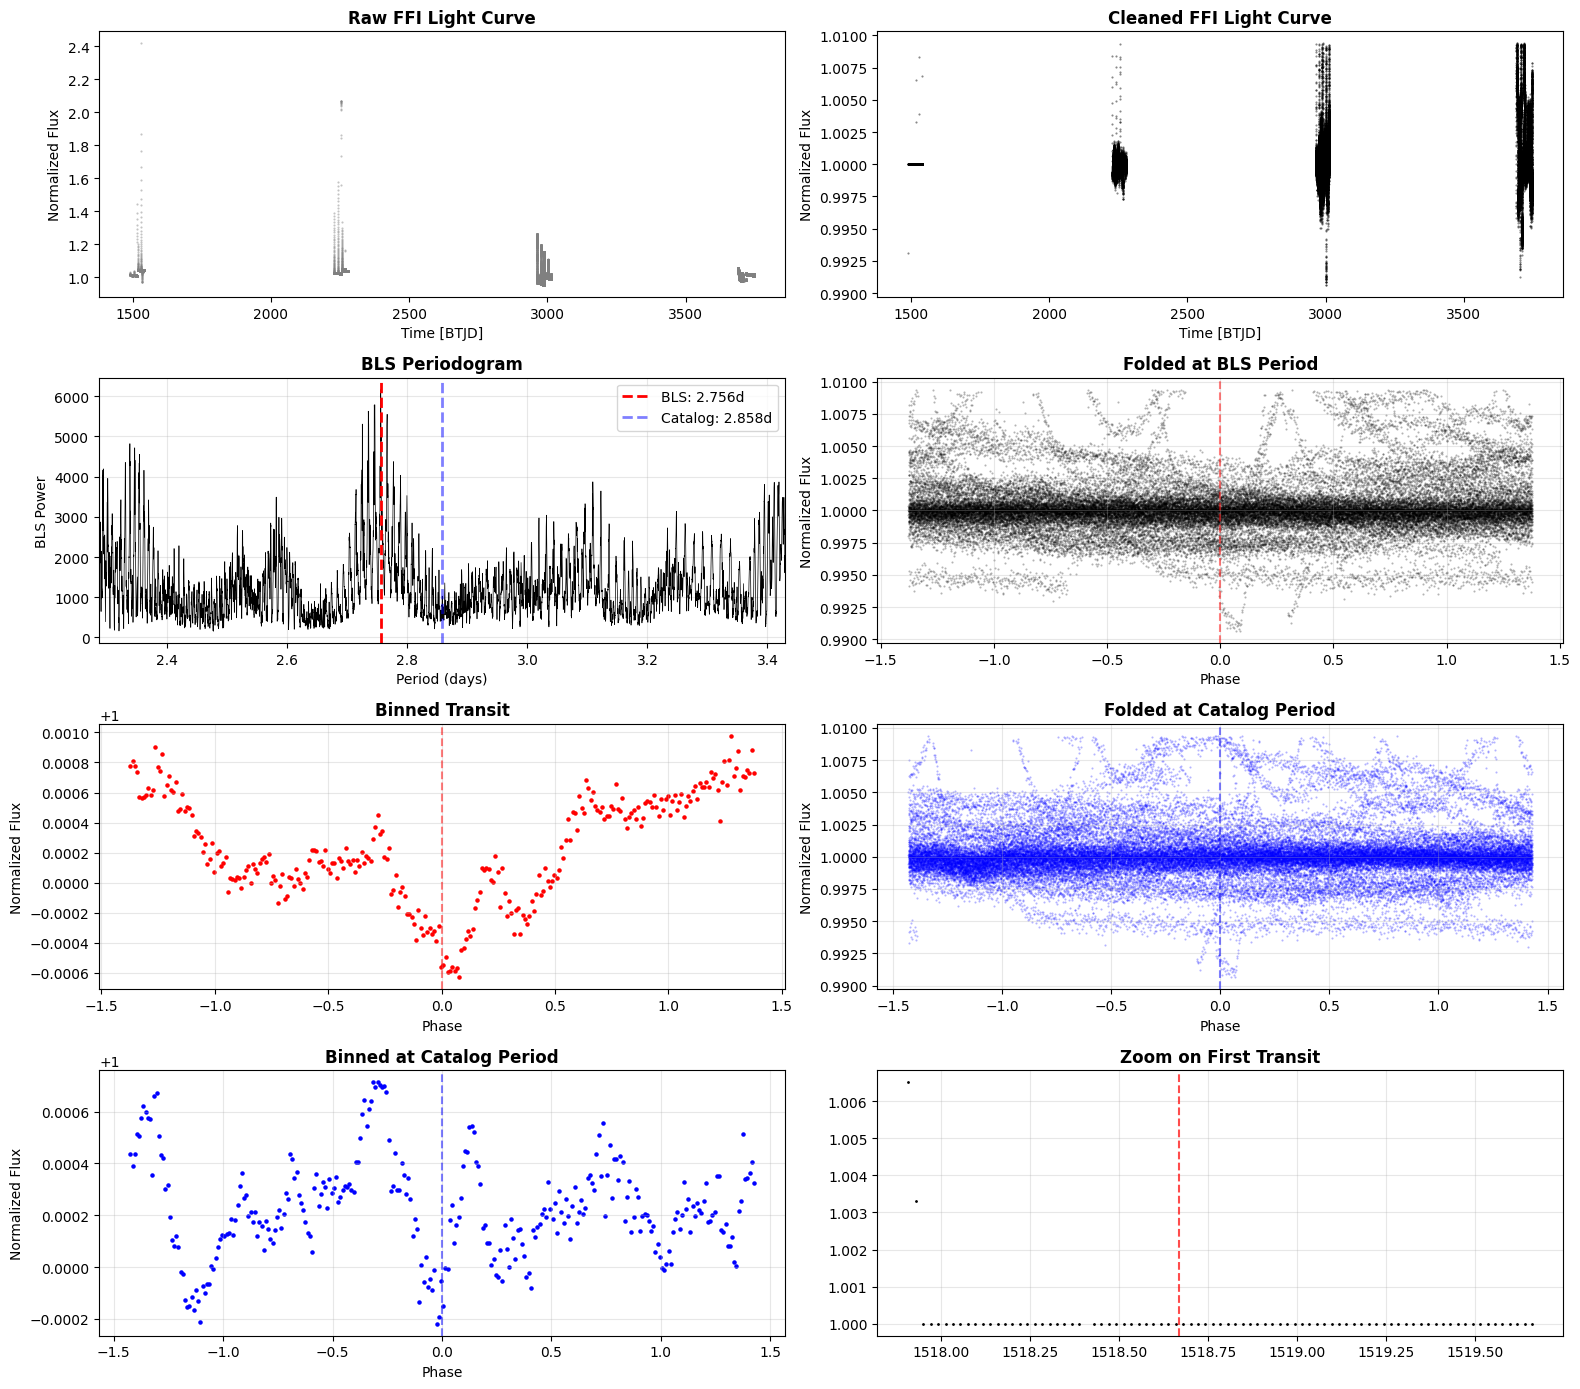


VETTING RESULTS
  TIC 133334108: ✓ GOOD CANDIDATE

Reasons:
  • Strong detection: P=2.8d, depth=432ppm, power=6164

BATCH ANALYSIS: 2 CANDIDATES

   Created directory: lightcurve_data

[1/2] Processing 1457.01...

  Looking through catalogs for transit parameters...
       Could not find TOI catalog: ORA-00904: 'PL_TRANDURERR1': invalid identifier
    Note: No transit depth/duration found in catalogs

Extracting FFI light curve for TIC 176860064
This may take awhile...
  Searching for FFI data...
    Found FFI data in 3 sector(s)
  Processing Sector 17...
    Using small circular aperture (r=2 pixels)
      Extracted 1000 data points
  Processing Sector 57...
    Using small circular aperture (r=2 pixels)
      Extracted 10791 data points
  Processing Sector 84...
    Using small circular aperture (r=2 pixels)
      Extracted 10555 data points

  Stitching 3 sector(s) together...
    Final: 22346 points, 1845.6 day baseline

BOX LEAST SQUARES (BLS) SEARCH
Detrending light curve...
  U

,toi,tic_id,catalog_period,bls_period,period_err,depth_ppm,depth_err_ppm,duration_hrs,duration_err_hrs,power,snr,n_transits,verdict,tmag,period_diff_pct,period_sigma,depth_diff_pct,depth_sigma,duration_diff_pct,duration_sigma
0,1457.01,176860064,6.376817,6.950661,0.003061,1716.241181,175.206923,7.92,0.792,53384.863501,319.660230,265,GOOD,7.1145,8.998900,187.454646,None,None,None,None
1,4391.01,66620917,5.291010,4.670312,0.003492,788.487417,77.516230,7.92,0.792,19682.833071,191.670873,315,GOOD,7.3010,-11.731173,177.712059,None,None,None,None


In [15]:
if __name__ == "__main__":
    
    df_missing = search_tois_with_missing_radius()
    
    if df_missing is not None and len(df_missing) > 0:
        
        candidate_index = 16  # **Change this** as needed to analyze different TOIs
        
        tic_id = int(df_missing['tic_id'].iloc[candidate_index])
        known_period = float(df_missing['pl_orbper'].iloc[candidate_index])
        toi_name = df_missing['toi'].iloc[candidate_index]
        tmag = df_missing['st_tmag'].iloc[candidate_index]
        
        known_period_err = None
        if 'pl_orbpererr1' in df_missing.columns and pd.notna(df_missing['pl_orbpererr1'].iloc[candidate_index]):
            known_period_err = float(df_missing['pl_orbpererr1'].iloc[candidate_index])
        
        results = analyze_missing_radius_toi(
            tic_id, known_period, known_period_err, toi_name, tmag
        )

    else:
        print("\n✗ No TOIs with missing radius found")

# To run batch analysis on top 20:
batch_analyze_missing_radius(df_missing, num_candidates=2, save_lcs=True)